<a href="https://colab.research.google.com/github/M17-hub/Neural-Network-for-AMHCD-Handwritten-Character-Recognition/blob/main/cnn_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cnn pytorch

In [1]:

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [2]:

transform = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

len(train_ds), len(test_ds)


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.07MB/s]


(60000, 10000)

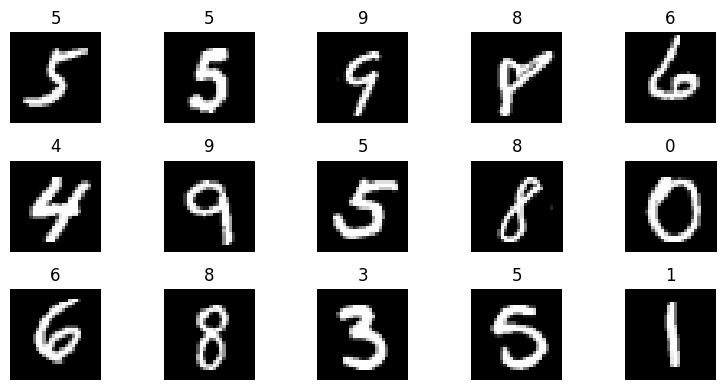

In [3]:

# Visualisation d'un mini-batch
images, labels = next(iter(train_loader))
plt.figure(figsize=(8,4))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(images[i,0].numpy(), cmap='gray')
    plt.title(int(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*1*1, 100)  # après 3x (5,5) + 3x pool(2,2) sur 28x28 => 1x1
        self.fc2   = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

def eval_epoch(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    ys, yps = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            total_correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)
            ys.append(y.cpu())
            yps.append(logits.argmax(1).cpu())
    return total_loss/total, total_correct/total, torch.cat(ys), torch.cat(yps)

train_hist, val_hist = {"loss": [], "acc": []}, {"loss": [], "acc": []}
for epoch in range(15):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    te_loss, te_acc, ys, yps = eval_epoch(model, test_loader)
    train_hist["loss"].append(tr_loss); train_hist["acc"].append(tr_acc)
    val_hist["loss"].append(te_loss);   val_hist["acc"].append(te_acc)
    print(f"Epoch {epoch+1:02d} | train acc={tr_acc:.4f} | test acc={te_acc:.4f}")


Epoch 01 | train acc=0.9022 | test acc=0.9772
Epoch 02 | train acc=0.9758 | test acc=0.9811
Epoch 03 | train acc=0.9840 | test acc=0.9878
Epoch 04 | train acc=0.9868 | test acc=0.9889
Epoch 05 | train acc=0.9899 | test acc=0.9874
Epoch 06 | train acc=0.9912 | test acc=0.9898
Epoch 07 | train acc=0.9929 | test acc=0.9900
Epoch 08 | train acc=0.9934 | test acc=0.9909
Epoch 09 | train acc=0.9945 | test acc=0.9923
Epoch 10 | train acc=0.9959 | test acc=0.9922
Epoch 11 | train acc=0.9959 | test acc=0.9906
Epoch 12 | train acc=0.9965 | test acc=0.9911
Epoch 13 | train acc=0.9966 | test acc=0.9909
Epoch 14 | train acc=0.9971 | test acc=0.9938
Epoch 15 | train acc=0.9969 | test acc=0.9923


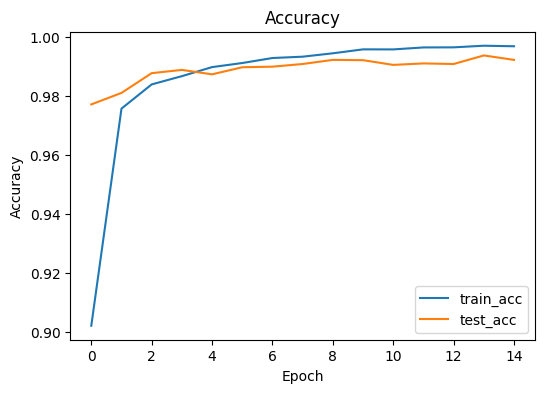

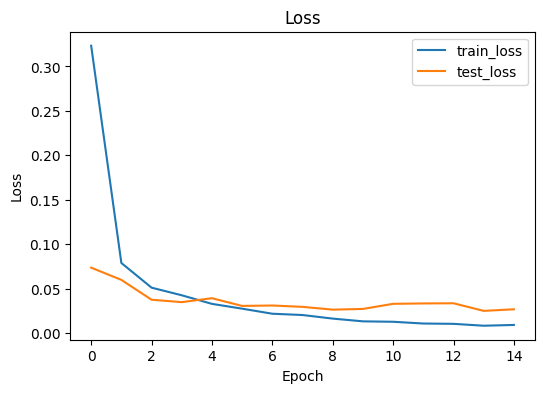

In [9]:

# Courbes
plt.figure(figsize=(6,4))
plt.plot(train_hist["acc"], label="train_acc")
plt.plot(val_hist["acc"], label="test_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_hist["loss"], label="train_loss")
plt.plot(val_hist["loss"], label="test_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


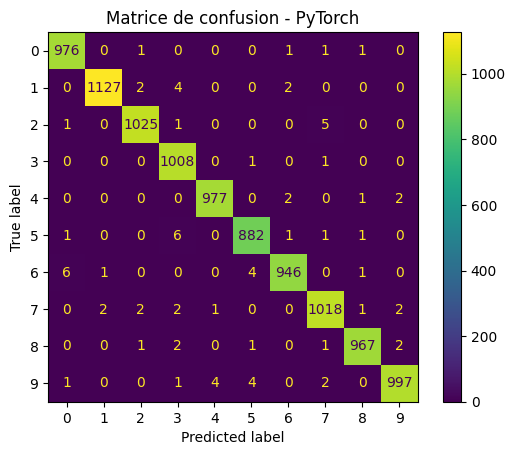

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [10]:

# Rapport final
cm = confusion_matrix(ys.numpy(), yps.numpy())
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='d')
plt.title("Matrice de confusion - PyTorch")
plt.show()

print(classification_report(ys.numpy(), yps.numpy()))
